# Import packages and data

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from sklearn import metrics
from scipy.spatial.distance import hamming
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA

for year in range(2014, 2023, 1):
    locals()['df_{}'.format(year)] = pd.read_csv('engineered_df/clubsize_'+str(year)+'.csv', index_col=0)

# Measure the clustering performance?

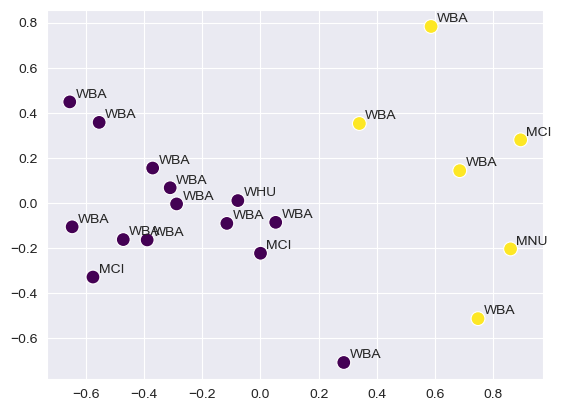

In [2]:
# Create global dataframes for the scaled data and PCA data for each season. Global frames means we can use the in functions for other models
for year in range(2014, 2023):

    # Take the relevant dataframe for the season
    dframe = globals()['df_{}'.format(year)]

    # select the numerical values
    num_cols = dframe.drop(columns=['target']).select_dtypes(include=np.number).columns
    scaler = MinMaxScaler()
    df_scaled = scaler.fit_transform(dframe[num_cols])
    globals()['df_{}'.format(year)] = dframe

    X_pca = PCA(n_components=4, svd_solver='auto', random_state=10).fit_transform(df_scaled)
    globals()['X_pca{}'.format(year)] = X_pca

X_pca2022 = np.c_[X_pca, df_2022['target']]
sns.scatterplot(x=X_pca2022[:,0] , y=X_pca2022[:,1] , c=X_pca2022[:,4], cmap='viridis', s=100, legend=False)
# Annotate label points
for i, language in enumerate (df_2022.abb):
    plt.annotate(language, (X_pca[i,0]+0.02, X_pca[i,1]+0.02))
plt.show()

In [360]:
# Measure accuracy for KMeans
def bitflip(array):
    """
    Insert a binary array, for each value, change from 0 to 1 or 1 to 0
    """
    out=[]
    for i in array:
        if i == 1:
            j=0
        else:
            j=1
        out.append(j)
    return out

# Initialise lists of results for different random states
rand_cluster_score = []
rand_rec_score = []
rand_prec_score = []

# Run 10 different random states to reduce error
for state in range(10):

    # Initialise lists for results from each season
    cluster_scores = []
    cluster_recall_scores = []
    cluster_prec_scores = []

    # Loop through the seasons
    for year in range(2014, 2023):

        dframe = globals()[f'df_{year}']

        # Fit the model
        X_pca = globals()[f'X_pca{year}']
        kmeans = KMeans(n_clusters=2, random_state=127)
        globals()[f'k_means_{year}'] = kmeans
        label = kmeans.fit_predict(X_pca)

        # Model performance, cannot control labelling (0,1) so bitflip labels if they do not majority match
        if hamming(dframe['target'], label) > 0.5:
            label = bitflip(label)
        cluster_score_season = metrics.accuracy_score(dframe['target'], label)
        cluster_recall_season = metrics.recall_score(dframe['target'], label)
        cluster_prec_season = metrics.precision_score(dframe['target'], label)
        cluster_scores.append(cluster_score_season)
        cluster_recall_scores.append(cluster_recall_season)
        cluster_prec_scores.append(cluster_prec_season)

    kmean_score = np.sum(cluster_scores) / len(range(2014, 2023))
    kmean_recscore = np.sum(cluster_recall_scores) / len(range(2014, 2023))
    kmean_precscore = np.sum(cluster_prec_scores) / len(range(2014, 2023))
    rand_cluster_score.append(kmean_score)
    rand_rec_score.append(kmean_recscore)
    rand_prec_score.append(kmean_precscore)

print(f'Cluster accuracy for the KMeans model is {np.sum(rand_cluster_score) / 1}')
print(f'Cluster recall for the KMeans model is {np.sum(rand_rec_score) / 1}')
print(f'Cluster precision for the KMeans model is {np.sum(rand_prec_score) / 1}')

Cluster accuracy for the KMeans model is 0.9666666666666666
Cluster recall for the KMeans model is 0.9444444444444444
Cluster precision for the KMeans model is 0.9563492063492064


#### Visualise the results for each season

In [488]:
# Find centroids (if not using KMEans)
def centeroidnp(arr):
    length = arr.shape[0]
    sum_x = np.sum(arr[:, 0])
    sum_y = np.sum(arr[:, 1])
    return sum_x/length, sum_y/length

def plot_seasons(method):
    """
    Pass the method used to calculate clusters and get plots for the last 9 seasons
    """

    # Initialise counters and subplot figure
    year_start = 2023 - (3 * 3)
    counter = 0
    fig, axes = plt.subplots(3, 3, figsize=(10, 10), sharex=True, sharey=False)
    fig.tight_layout(pad=3.0)

    # Iterate through each figure location
    for row in range(3):
        for col in range(3):

            # Set the co-ordinates and the classes from the global data tables
            X_pca = globals()[f'X_pca{year_start + counter}']
            label = globals()[f'{method}_{year_start + counter}'].fit_predict(X_pca)

            #Add the target and the prediction to the PCS table
            X_pca = np.c_[X_pca, globals()['df_{}'.format(year_start + counter)]['target']]
            X_pca = np.c_[X_pca, label]
            #Plot the clusters for each year
            sns.scatterplot(ax=axes[row, col], x=X_pca[:, 0], y=X_pca[:, 1],
                            c=X_pca[:, 4], cmap='viridis', style=X_pca[:, 5], s=100)

            axes[row, col].set_title(f'{year_start + counter}')
            axes[row, col].set_ylabel(ylabel='')

            # Annotate points with team abbreviations
            for i, team_abb in enumerate(globals()[f'df_{year_start + counter}'].abb):
                axes[row, col].annotate(team_abb, (X_pca[i, 0] + 0.02, X_pca[i, 1] + 0.02))

            # Plot the centroids
            try:
                centroids = globals()[f'{method}_{year_start + counter}'].cluster_centers_
            except:
                cent1 = centeroidnp(X_pca[X_pca[:,5] != 0][:,:4])
                cent0 = centeroidnp(X_pca[X_pca[:,5] == 0][:,:4])
                centroids = np.array([[cent0[0],cent0[1]],[cent1[0],cent1[1]]])
            sns.scatterplot(ax=axes[row, col], x=centroids[:, 0], y=centroids[:, 1],
                            s=80, color='k')
            counter += 1

    axes[2, 1].set_xlabel(xlabel='PCA2')
    axes[1, 0].set_ylabel(ylabel='PCA1')

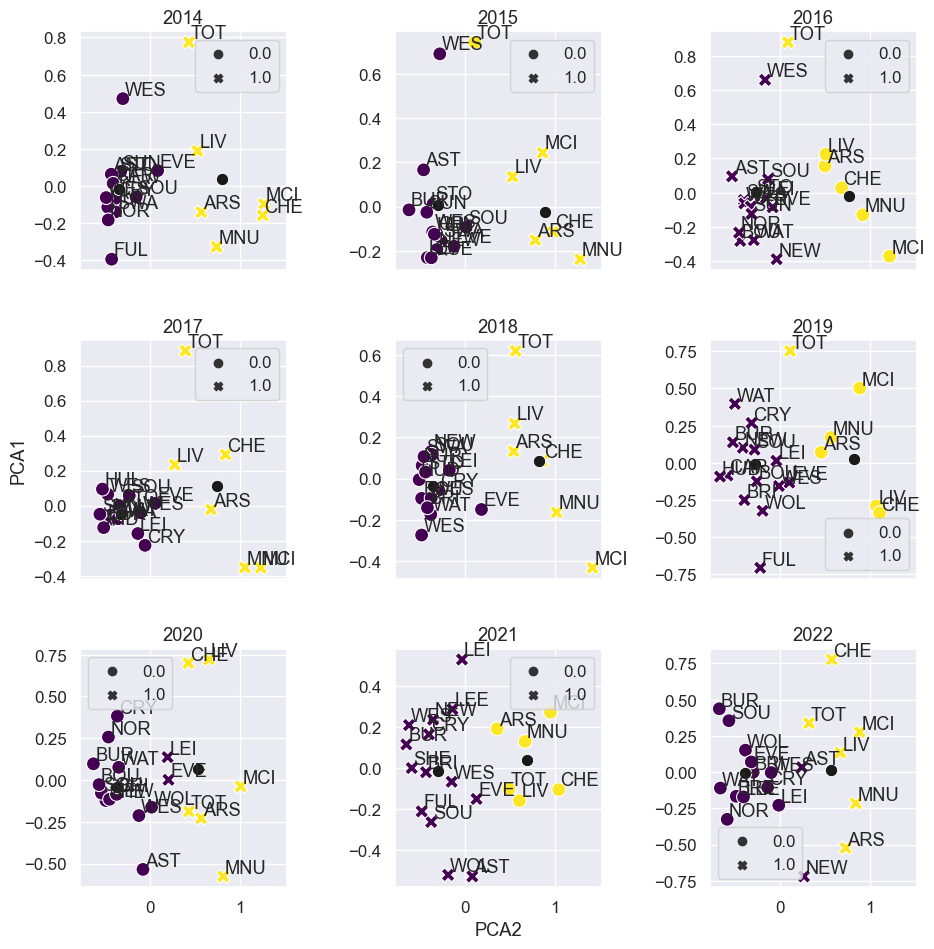

In [486]:
plot_seasons('k_means')

##### Clearly a better model is required
# DBScan

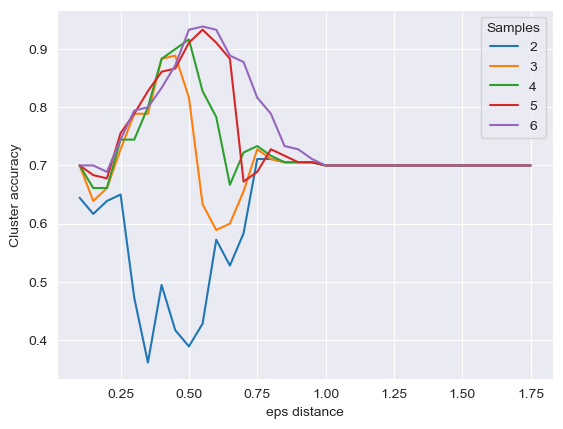

In [346]:
# Calculate clusters over the seasons for DBSCAN, grid search for optimal parameters
for samp in range(2, 7):
    sample_cluster_score = []
    for dist in np.arange(0.1, 1.8, 0.05):
        cluster_scores = []
        for year in range(2014, 2023):
            dframe = globals()['df_{}'.format(year)]

            # Fit the model and built lists of metrics
            X_pca = globals()['X_pca{}'.format(year)]
            dbs = DBSCAN(eps=dist, min_samples=samp).fit(X_pca)
            globals()['dbs_{}'.format(year)] = dbs
            label = -dbs.fit_predict(X_pca)

            # Model performance, cannot control labelling (0,1) so bitflip labels if they do not majority match
            # -ve sign is required on 'label' since DBScan assigns -1 to points that are unclustered, in our case this might as well be class 1
            if hamming(dframe['target'], label) > 0.5:
                label = bitflip(label)
            cluster_score_season = metrics.accuracy_score(dframe['target'], label)
            cluster_scores.append(cluster_score_season)

        dbs_score = np.sum(cluster_scores) / len(range(2014, 2023))
        sample_cluster_score.append(dbs_score)
    plt.plot(np.arange(0.1, 1.8, 0.05), sample_cluster_score)
plt.xlabel(xlabel='eps distance')
plt.ylabel(ylabel='Cluster accuracy')
plt.legend(range(2, 7), title='Samples')
plt.show()

Cluster accuracy for the KMeans model is 0.8888888888888888
Cluster recall for the KMeans model is 0.8148148148148148
Cluster precision for the KMeans model is 0.8392857142857143


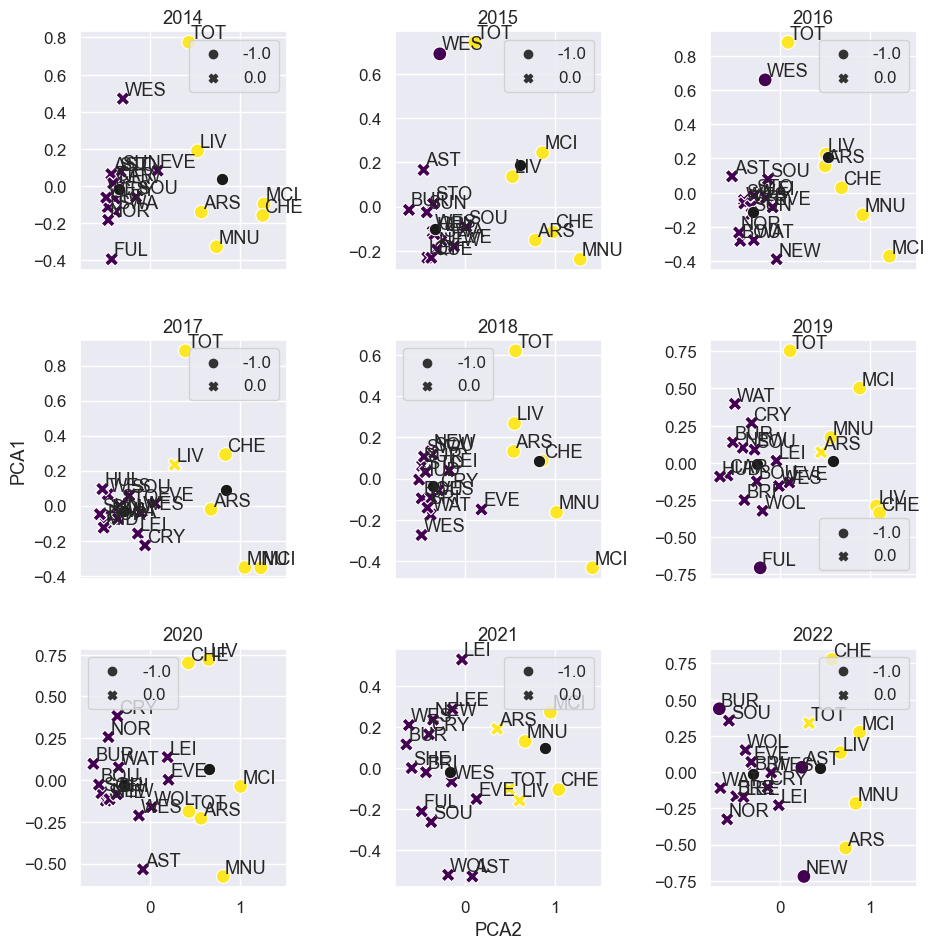

In [489]:
# Plot over the seasons using the optimal model

cluster_scores = []
cluster_recall_scores = []
cluster_prec_scores = []

for year in range(2014, 2023):

    # Fit the model get labels
    X_pca = globals()['X_pca{}'.format(year)]
    dbs = DBSCAN(eps=0.55, min_samples=6).fit(X_pca)
    globals()['dbs_{}'.format(year)] = dbs
    label = dbs.fit_predict(X_pca)

    # Cluster performance, average difference between target and label (negative label due to DBSCAN labelling)
    cluster_score_season = metrics.accuracy_score(dframe['target'], -label)
    cluster_recall_season = metrics.recall_score(dframe['target'], -label)
    cluster_prec_season = metrics.precision_score(dframe['target'], -label)
    cluster_scores.append(cluster_score_season)
    cluster_recall_scores.append(cluster_recall_season)
    cluster_prec_scores.append(cluster_prec_season)

# Caluculate scores and print, then plot each season
dbs_score = np.sum(cluster_scores) / len(range(2014, 2023))
dbs_recscore = np.sum(cluster_recall_scores) / len(range(2014, 2023))
dbs_precscore = np.sum(cluster_prec_scores) / len(range(2014, 2023))
print(f'Cluster accuracy for the KMeans model is {dbs_score}')
print(f'Cluster recall for the KMeans model is {dbs_recscore}')
print(f'Cluster precision for the KMeans model is {dbs_precscore}')
plot_seasons('dbs')

# Gaussian Mixture model

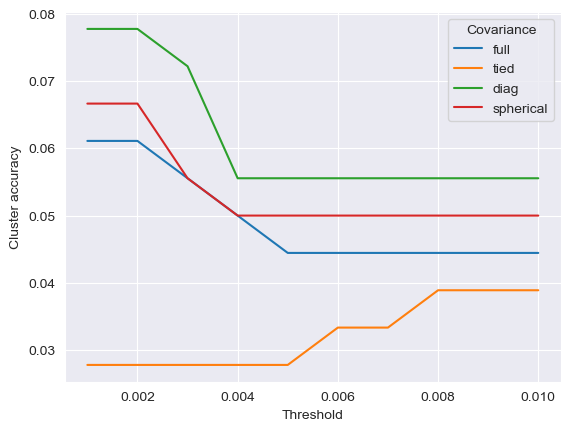

In [348]:
# Calculate clusters over the seasons for GM model, grid search for optimal parameters
for cov in ['full', 'tied', 'diag', 'spherical']:
    rand_cluster_score = []
    for to in np.arange(0.001, 0.011, 0.001):
        cluster_score = []
        for year in range(2014, 2023):
            dframe = globals()['df_{}'.format(year)]

            X_pca = globals()[f'X_pca{year}']
            gm = GaussianMixture(n_components=2, random_state=0, tol=to, covariance_type=cov).fit(X_pca)
            globals()['gm_{}'.format(year)] = gm
            label = gm.fit_predict(X_pca)

            # Cluster performance, average difference between target and label
            dframe['cluster'] = label
            diff = abs(np.array(dframe['target']) - np.array(dframe['cluster']))
            cluster_score.append(np.sum(diff) / 20)

        gm_score = np.sum(cluster_score) / len(range(2014, 2023))
        rand_cluster_score.append(gm_score)
    plt.plot(np.arange(0.001, 0.011, 0.001), rand_cluster_score)
plt.xlabel(xlabel='Threshold')
plt.ylabel(ylabel='Cluster accuracy')
plt.legend(['full', 'tied', 'diag', 'spherical'], title='Covariance')
plt.show()

Cluster accuracy for the GM model is 0.9722222222222222
Cluster recall for the GM model is 0.925925925925926
Cluster precision for the GM model is 0.9841269841269842


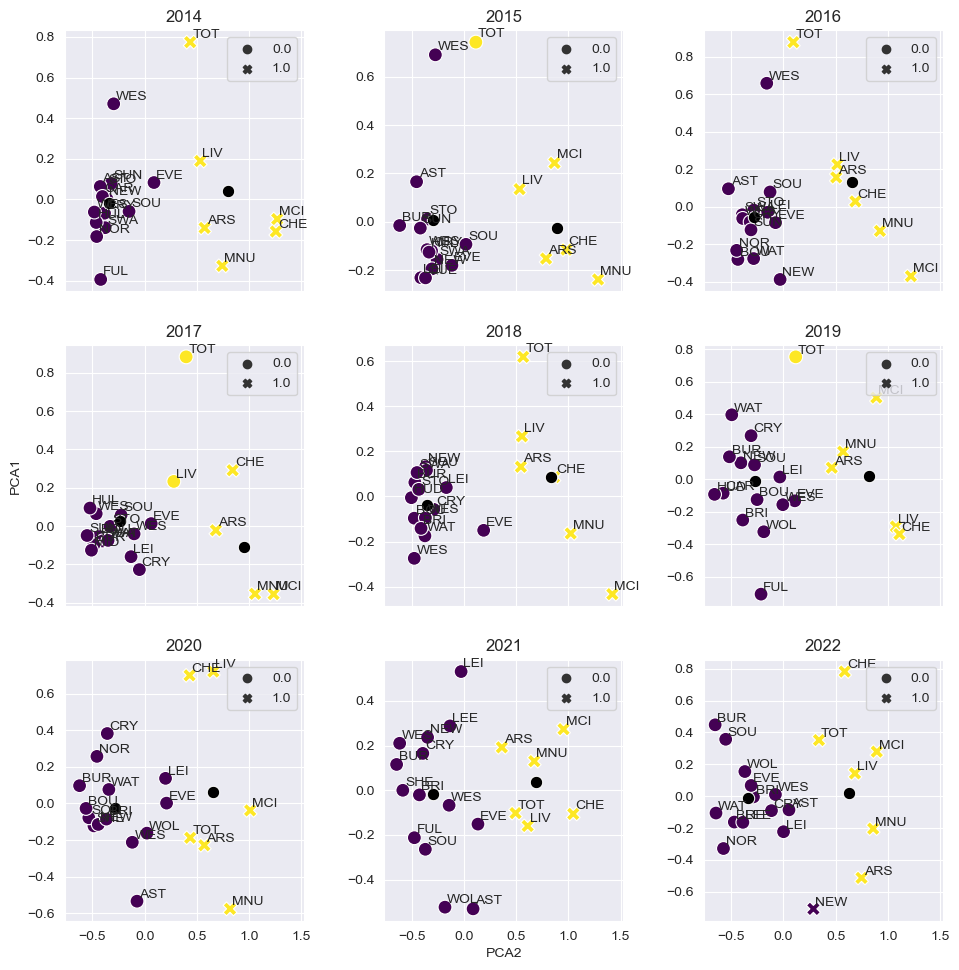

In [375]:
# Plot over the seasons using the optimised model
cluster_scores = []
cluster_recall_scores = []
cluster_prec_scores = []
for year in range(2014, 2023):
    dframe = globals()['df_{}'.format(year)]

    # Fit the GM model
    X_pca = globals()[f'X_pca{year}']
    gm = GaussianMixture(n_components=2, random_state=0, covariance_type='tied').fit(X_pca)
    globals()['gm_{}'.format(year)] = gm
    label = gm.fit_predict(X_pca)

    # Cluster performance, average difference between target and label
    cluster_score_season = metrics.accuracy_score(dframe['target'], label)
    cluster_recall_season = metrics.recall_score(dframe['target'], label)
    cluster_prec_season = metrics.precision_score(dframe['target'], label)
    cluster_scores.append(cluster_score_season)
    cluster_recall_scores.append(cluster_recall_season)
    cluster_prec_scores.append(cluster_prec_season)

# Calculate and print the scores, then plot the graphs
gm_score = np.sum(cluster_scores) / len(range(2014, 2023))
gm_recscore = np.sum(cluster_recall_scores) / len(range(2014, 2023))
gm_precscore = np.sum(cluster_prec_scores) / len(range(2014, 2023))
print(f'Cluster accuracy for the GM model is {gm_score}')
print(f'Cluster recall for the GM model is {gm_recscore}')
print(f'Cluster precision for the GM model is {gm_precscore}')

plot_seasons('gm')

# Cluster metrics over time
#### 3 different measures of cluster definition

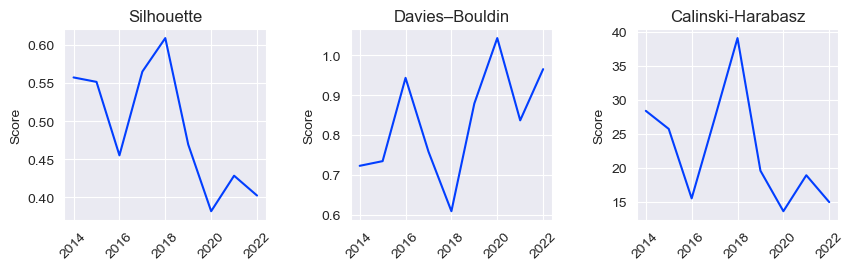

In [414]:
# Initialise score lists
sil_score = []
davbou_score = []
calhar_score = []

# Iterate over each season and calulate the
for year in range(2014, 2023):

    # Take the already calculated cluster models, get labels
    dframe = globals()[f'df_{year}']
    X_pca = globals()[f'X_pca{year}']
    gm = globals()[f'gm_{year}']
    label = gm.fit_predict(X_pca)

    # Cluster metrics, silhouette/inertia for predicted labels
    # sil_score.append(metrics.silhouette_score(X_pca, label))
    # davbou_score.append(metrics.davies_bouldin_score(X_pca, label))
    # calhar_score.append(metrics.calinski_harabasz_score(X_pca, label))

    # Cluster metrics for actual labels
    sil_score.append(metrics.silhouette_score(X_pca, dframe['target']))
    davbou_score.append(metrics.davies_bouldin_score(X_pca, dframe['target']))
    calhar_score.append(metrics.calinski_harabasz_score(X_pca, dframe['target']))

# Plot each score over the seasons, initialise figure
fig, axes = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=False,)
fig.tight_layout(pad=3.0)

score = [sil_score, davbou_score, calhar_score]
titles = ['Silhouette', 'Davies–Bouldin', 'Calinski-Harabasz']
palette = sns.color_palette("bright")

# Insert each plot into figure location
for col in range(3):
    sns.set_palette("bright")
    g=sns.lineplot(ax=axes[col],
                 x=range(2014, 2023), y=score[col], palette='bright')
    xlabels = ['{:.0f}'.format(x) for x in range(2014, 2023)]
    axes[col].set_title(f'{titles[col]}')
    axes[col].set_ylabel(ylabel='Score')
    g.set_xticks(range(2014,2023,2))
    g.set_xticklabels(range(2014, 2023,2), rotation=45)

plt.show()

# Investigate which features have the greatest impact
### PCA decomposition

In [490]:
# For the 2022 season, decompose the 1st principal component
from sklearn import decomposition
scaler = MinMaxScaler()
num_cols = df_2022.drop(columns='target').select_dtypes(include=np.number).columns
df_scaled = scaler.fit_transform(df_2022[num_cols])

pca = decomposition.PCA(n_components=4)
X = pca.fit_transform(df_scaled)
loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2', 'PC3', 'PC4'], index=feats)
ld = pd.DataFrame(loadings).sort_values(by='PC1', ascending=False)

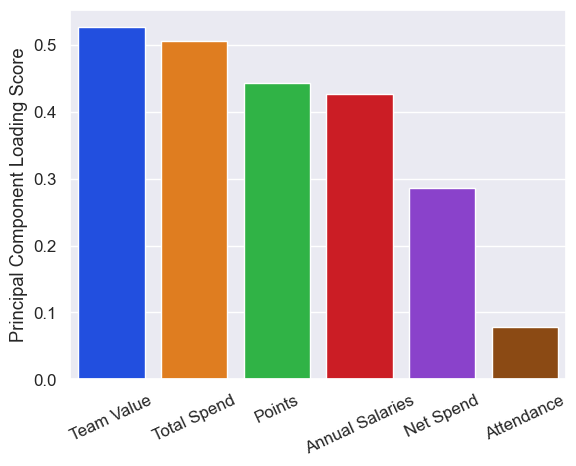

In [453]:
# Plot these values
sns.set_palette("bright")
col_feat = ['Team Value', 'Total Spend', 'Points', 'Annual Salaries', 'Net Spend', 'Attendance']
g = sns.barplot(x = col_feat, y=ld.PC1, palette='bright')
plt.ylabel(ylabel='Principal Component Loading Score')
g.set_xticklabels(col_feat, rotation=25)
plt.show()

In [474]:
df_2022

,Team,Pts,abb,target,att_percent,TotValue,annual_wage,total_spend,net_spend
0,Manchester City,93.0,MCI,1,0.958576,1000000000,151552000,134.50,40.700
1,Liverpool,92.0,LIV,1,0.980286,918900000,144412000,87.00,57.450
2,Chelsea,74.0,CHE,1,0.892052,914500000,175890000,118.00,-1.950
3,Tottenham Hotspur,71.0,TOT,1,0.910751,689350000,110190000,95.90,61.780
4,Arsenal,69.0,ARS,1,0.985289,613050000,114370000,167.42,136.020
5,Manchester United,58.0,MNU,1,0.976909,769150000,238850000,140.00,109.300
6,West Ham United,56.0,WES,0,0.937104,354900000,74556000,74.50,70.265
7,Leicester City,52.0,LEI,0,0.989682,526549999,74370000,67.60,63.600
8,Brighton & Hove Albion,51.0,BRI,0,0.973050,318000000,46470000,75.00,-3.500
9,Wolverhampton Wanderers,51.0,WOL,0,0.957629,376950000,57270000,37.60,5.800


### Changing the features one by one, keeping the rest constant

In [483]:
# Select team to test
team_test = 'Aston Villa'
index = df_2022[df_2022.Team == team_test].index[0]

# Load df and create a results df
feats = ['total_spend', 'TotValue', 'annual_wage', 'Pts', 'net_spend', 'att_percent']
for year in range(2014, 2023, 1):
    locals()['df_{}'.format(year)] = pd.read_csv('clubsize/clubsize_'+str(year)+'.csv', index_col=0)
df_change = pd.DataFrame(np.zeros((3,6)), columns=[feats])
df_change.iloc[0,:] = df_2022.loc[index,feats]

# Initialise lists and begin to iterate through each feature, changing them until the cluster label changes
change_list = []
pct_change = []
for feature in feats:

    increment = 0.01 * df_2022.loc[index,feature]
    feature_value = df_2022.loc[index,feature]
    old_label = df_2022.loc[index,'target']
    new_label = old_label
    pct= 0

    while (new_label == old_label) and (feature_value < 10*df_change.loc[0,feature][0]):

        #Change feature incrementally
        feature_value += increment
        df_2022.loc[index,feature] = feature_value
        # Scale
        num_cols = df_2022.drop(columns=['target']).select_dtypes(include=np.number).columns
        scaler = MinMaxScaler()
        df_scaled = scaler.fit_transform(df_2022[num_cols])
        # PCA
        X_pca = PCA(n_components=4, svd_solver='auto', random_state=11).fit_transform(df_scaled)
        # Fit model, set new cluster value
        gm = GaussianMixture(n_components=2, random_state=0, covariance_type='tied').fit(X_pca)
        labels = gm.fit_predict(X_pca)
        pct += 1
        new_label = labels[index]

    change_list.append(feature_value)
    pct_change.append(pct)
    df_2022.loc[index,feature] = df_change.loc[0,feature][0]

df_change.iloc[1,:] = change_list
df_change.iloc[2,:] = pct_change
df_change['rows'] = ['Current Values', 'Threshold values', '% change']
df_change.set_index('rows', inplace=True)
df_change

,total_spend,TotValue,annual_wage,Pts,net_spend,att_percent
rows,,,,,,
"(Current Values,)",129.8200,487750000.0,71490000.0,45.00,2.8200,0.975845
"(Threshold values,)",140.2056,570667500.0,88647600.0,64.35,28.2282,9.768205
"(% change,)",8.0000,17.0,24.0,43.00,901.0000,901.000000


### Changing each feature simoultaneously (change each by 1%)

In [482]:
# Select team to test
team_test = 'Tottenham Hotspur'
feats = ['total_spend', 'TotValue', 'annual_wage', 'Pts', 'net_spend', 'att_percent']

# Load df and create a results df
for year in range(2014, 2023, 1):
    locals()['df_{}'.format(year)] = pd.read_csv('clubsize/clubsize_'+str(year)+'.csv', index_col=0)
df_change = pd.DataFrame(np.zeros((3,6)), columns=[feats])
df_change.iloc[0,:] = df_2022.loc[index,feats]

index = df_2022[df_2022.Team == team_test].index[0]
old_label = df_2022.loc[index,'target']
new_label = old_label
pct_change = []
pct= 0

# Begin loop that records the feature value the moment the cluster label changes
while (new_label == old_label) and (feature_value > 0):

    change_list = []

    # Loop through the features changing their value incrementally
    for feature in feats:

        increment = 0.01 * df_2022.loc[index,feature]
        feature_value = df_2022.loc[index,feature]

        feature_value -= increment
        df_2022.loc[index,feature] = feature_value
        change_list.append(feature_value)

    # Scale
    num_cols = df_2022.drop(columns=['target']).select_dtypes(include=np.number).columns
    scaler = MinMaxScaler()
    df_scaled = scaler.fit_transform(df_2022[num_cols])

    # PCA
    X_pca = PCA(n_components=4, svd_solver='auto', random_state=10).fit_transform(df_scaled)
    # Fit model
    gm = GaussianMixture(n_components=2, random_state=0, covariance_type='tied').fit(X_pca)
    labels = gm.fit_predict(X_pca)
    new_label = labels[index]
    pct -= 1

pct_change.append(pct)

# Reset values in the OG df
df_2022.loc[index,feature] = df_change.loc[0,feature][0]
# Populate results df
df_change.iloc[1,:] = change_list
df_change.iloc[2,:] = pct_change
df_change['rows'] = ['Current Values', 'Threshold values', '% change']
df_change.set_index('rows', inplace=True)
df_change

,total_spend,TotValue,annual_wage,Pts,net_spend,att_percent
rows,,,,,,
"(Current Values,)",129.820000,4.877500e+08,7.149000e+07,45.000000,2.820000,0.975845
"(Threshold values,)",85.004309,6.110294e+08,9.767075e+07,62.933326,54.760857,0.807276
"(% change,)",-12.000000,-1.200000e+01,-1.200000e+01,-12.000000,-12.000000,-12.000000
